In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px


from IPython.display import display, HTML
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as py

import datetime as DT
import hmac
import matplotlib.pyplot as plt
import seaborn as sns
import html5lib
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML

py.init_notebook_mode(connected=True)

# magic word for producing visualizations in notebook
%matplotlib inline

In [92]:
#load data sets
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
sample= pd.read_csv("sample_submission.csv")

In [93]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [94]:
#row and column number
train.shape

(913000, 4)

In [95]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [96]:
store1item1 = train.loc[(train['store'] == 1) & (train['item'] == 1)]
store1item1.head()
store1item1.tail()

,date,store,item,sales
1821,2017-12-27,1,1,14
1822,2017-12-28,1,1,19
1823,2017-12-29,1,1,15
1824,2017-12-30,1,1,27
1825,2017-12-31,1,1,23


In [97]:
store1item1.shape

(1826, 4)

In [98]:
store1item1['date']  =  pd.to_datetime(store1item1['date'],infer_datetime_format = True)             #convert from string to datetime

indexedDataset  =  store1item1.set_index(['date'])
indexedDataset= indexedDataset.drop(columns=["store","item"])
indexedDataset.head(5)

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


In [99]:
# Determine rolling statistics
def rolling_means(time_series):
    rolmean  =  time_series.rolling(window = 12).mean()    #window size 12 denotes 12 months, giving rolling mean at yearly level
    rolstd  =  time_series.rolling(window = 12).std()

    orig  =  plt.plot(time_series, color = 'blue', label = 'Original')
    mean  =  plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std  =  plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

In [100]:
#Perform Augmented Dickey–Fuller test:
def adf_test(time_series):
    
    from statsmodels.tsa.stattools import adfuller
    dftest  =  adfuller(time_series, autolag = 'AIC')

    dfoutput  =  pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        
        dfoutput['Critical Value (%s)'%key]  =  value
    
    print('Results of Dickey Fuller Test:') 
    print(dfoutput)

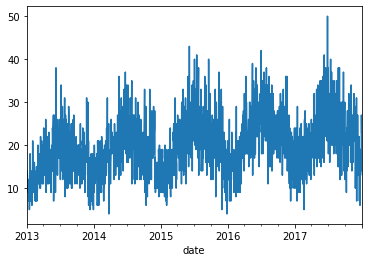

In [101]:
indexedDataset['sales'].plot()

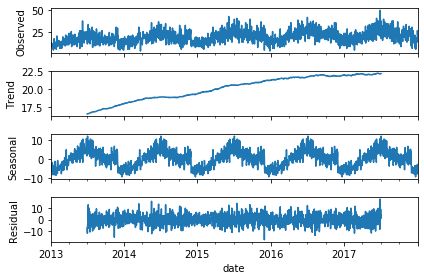

In [102]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig = seasonal_decompose(indexedDataset['sales'], model='additive', freq=365).plot()

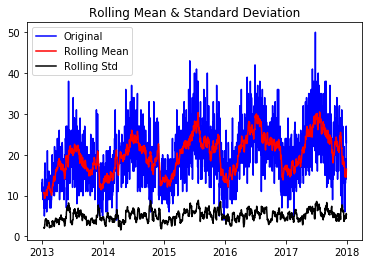

In [103]:
rolling_means(indexedDataset["sales"])

In [104]:
adf_test(indexedDataset['sales'])

Results of Dickey Fuller Test:
Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


In [105]:

#log scale transform
import numpy as np
indexedDataset_logScale  =  np.log(indexedDataset)

In [106]:
adf_test(indexedDataset_logScale.sales)

Results of Dickey Fuller Test:
Test Statistic                   -3.594424
p-value                           0.005869
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


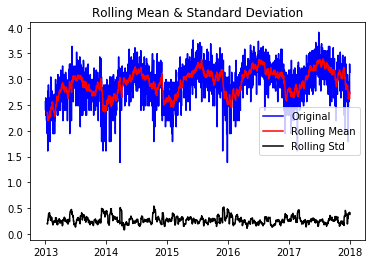

In [107]:

rolling_means(indexedDataset_logScale)

In [108]:
movingAverage  =  indexedDataset_logScale.rolling(window = 12).mean()
datasetLogScaleMinusMovingAverage  =  indexedDataset_logScale - movingAverage

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace = True)

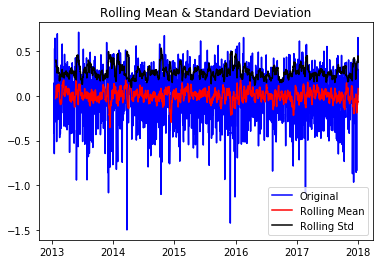

In [109]:
rolling_means(datasetLogScaleMinusMovingAverage)

In [110]:
adf_test(datasetLogScaleMinusMovingAverage.sales)

Results of Dickey Fuller Test:
Test Statistic                -1.031707e+01
p-value                        3.077488e-18
#Lags Used                     2.000000e+01
Number of Observations Used    1.794000e+03
Critical Value (1%)           -3.434000e+00
Critical Value (5%)           -2.863152e+00
Critical Value (10%)          -2.567628e+00
dtype: float64


In [111]:
exponentialDecayWeightedAverage  =  indexedDataset_logScale.ewm(halflife = 12, min_periods = 0, adjust = True).mean()

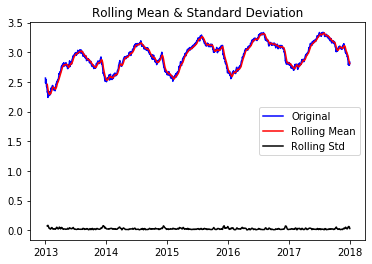

In [112]:
rolling_means(exponentialDecayWeightedAverage)

In [113]:
adf_test(exponentialDecayWeightedAverage.sales)

Results of Dickey Fuller Test:
Test Statistic                   -3.666915
p-value                           0.004603
#Lags Used                       24.000000
Number of Observations Used    1801.000000
Critical Value (1%)              -3.433986
Critical Value (5%)              -2.863146
Critical Value (10%)             -2.567625
dtype: float64


In [114]:
datasetLogDiffShifting  =  indexedDataset_logScale - indexedDataset_logScale.shift()

In [115]:
datasetLogDiffShifting.dropna(inplace = True)

In [116]:
datasetLogDiffShifting.head()

,sales
date,
2013-01-02,-0.167054
2013-01-03,0.241162
2013-01-04,-0.074108
2013-01-05,-0.262364
2013-01-06,0.182322


In [117]:
adf_test(datasetLogDiffShifting.sales)

Results of Dickey Fuller Test:
Test Statistic                -1.259629e+01
p-value                        1.775858e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.802000e+03
Critical Value (1%)           -3.433984e+00
Critical Value (5%)           -2.863145e+00
Critical Value (10%)          -2.567625e+00
dtype: float64


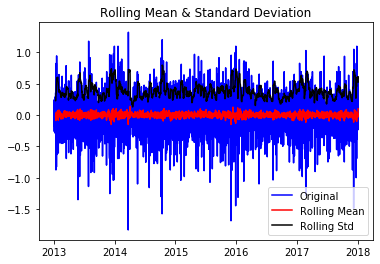

In [118]:

rolling_means(datasetLogDiffShifting)

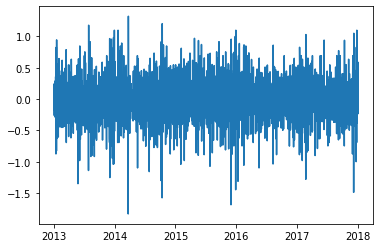

In [119]:
plt.plot(datasetLogDiffShifting)

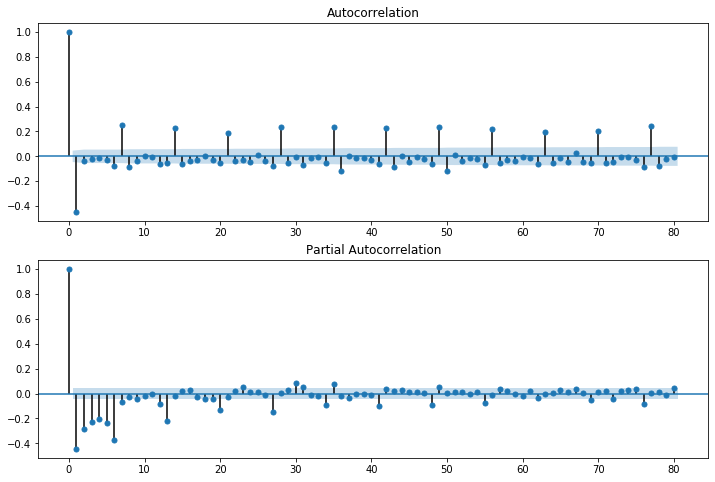

In [120]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(datasetLogDiffShifting.sales, lags=80, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = plot_pacf(datasetLogDiffShifting.sales, lags=80, ax=ax2)

In [121]:
train1, test1 = datasetLogDiffShifting[0:len(datasetLogDiffShifting)-100], datasetLogDiffShifting[len(datasetLogDiffShifting)-100:]
train1.head()

,sales
date,
2013-01-02,-0.167054
2013-01-03,0.241162
2013-01-04,-0.074108
2013-01-05,-0.262364
2013-01-06,0.182322


In [122]:
test1.head()

,sales
date,
2017-09-23,0.278713
2017-09-24,-0.432864
2017-09-25,-0.538997
2017-09-26,0.251314
2017-09-27,0.405465


In [123]:

print(train1.shape)
print(test1.shape)

(1725, 1)
(100, 1)


In [124]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA (train1, order=(7,0,7))
model_fit = model.fit()
print(model_fit.summary())


                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                 1725
Model:                     ARMA(7, 7)   Log Likelihood                -117.144
Method:                       css-mle   S.D. of innovations              0.256
Date:                Sun, 09 May 2021   AIC                            266.288
Time:                        21:59:48   BIC                            353.536
Sample:                    01-02-2013   HQIC                           298.564
                         - 09-22-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0004        nan        nan        nan         nan         nan
ar.L1.sales    -0.9827        nan        nan        nan         nan         nan
ar.L2.sales    -0.9825        nan        nan    

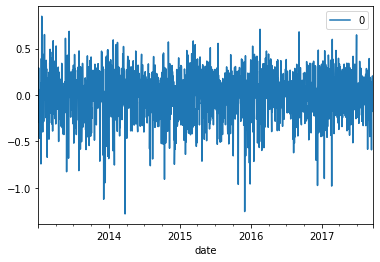

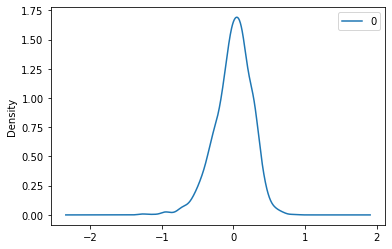

                 0
count  1725.000000
mean     -0.000724
std       0.258078
min      -1.279376
25%      -0.146920
50%       0.021355
75%       0.169429
max       0.847395


In [125]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [126]:
model_fit.fittedvalues.head()

date
2013-01-02    0.000440
2013-01-03   -0.050376
2013-01-04    0.220612
2013-01-05   -0.225109
2013-01-06    0.218109
dtype: float64

In [127]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(train1, model_fit.fittedvalues)
print('Train MSE: %.3f' % error)

Train MSE: 0.067


In [129]:
# make predictions
predictions = model_fit.predict(start=len(train1), end=len(datasetLogDiffShifting)-1, dynamic=False)

In [132]:
error = mean_squared_error(test1, predictions)
print('Test MSE: %.3f' % error)
# plot results

Test MSE: 0.136


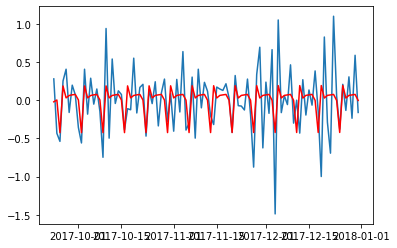

In [133]:
pyplot.plot(test1)
pyplot.plot(predictions, color='red')
pyplot.show()

In [134]:
datasetLogDiffShifting.tail()

,sales
date,
2017-12-27,-0.133531
2017-12-28,0.305382
2017-12-29,-0.236389
2017-12-30,0.587787
2017-12-31,-0.160343


In [135]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA (datasetLogDiffShifting, order=(7,0,7))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                 1825
Model:                     ARMA(7, 7)   Log Likelihood                -127.375
Method:                       css-mle   S.D. of innovations              0.257
Date:                Sun, 09 May 2021   AIC                            286.751
Time:                        22:02:49   BIC                            374.900
Sample:                    01-02-2013   HQIC                           319.268
                         - 12-31-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002        nan        nan        nan         nan         nan
ar.L1.sales    -0.9917   1.24e-05  -7.98e+04      0.000      -0.992      -0.992
ar.L2.sales    -0.9909   1.22e-05  -8.12e+04    

In [136]:
index_future_dates = pd.date_range(start='2017-12-31',end='2018-01-30')
pred=model_fit.predict(start=len(datasetLogDiffShifting),end=len(datasetLogDiffShifting)+30).rename('ARIMA PREDICTION')
pred.index=index_future_dates

In [138]:
print(pred)

2017-12-31   -0.611142
2018-01-01    0.154634
2018-01-02    0.057382
2018-01-03    0.059514
2018-01-04   -0.000301
2018-01-05    0.171757
2018-01-06    0.042747
2018-01-07   -0.485373
2018-01-08    0.155988
2018-01-09    0.057020
2018-01-10    0.059736
2018-01-11   -0.000536
2018-01-12    0.172243
2018-01-13    0.042208
2018-01-14   -0.485163
2018-01-15    0.156216
2018-01-16    0.056648
2018-01-17    0.059958
2018-01-18   -0.000770
2018-01-19    0.172729
2018-01-20    0.041668
2018-01-21   -0.484952
2018-01-22    0.156442
2018-01-23    0.056277
2018-01-24    0.060180
2018-01-25   -0.001003
2018-01-26    0.173214
2018-01-27    0.041127
2018-01-28   -0.484739
2018-01-29    0.156668
2018-01-30    0.055907
Freq: D, Name: ARIMA PREDICTION, dtype: float64


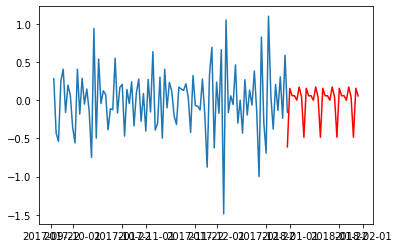

In [140]:
pyplot.plot(test1)
pyplot.plot(pred, color='red')
pyplot.show()